In [148]:
from __future__ import division
import cPickle as pickle
import pandas as pd
import numpy as np
import librosa
from itertools import compress
import matplotlib.pyplot as plt
#%matplotlib inline
import thinkdsp
import thinkplot
from itertools import compress
import os
from collections import Counter


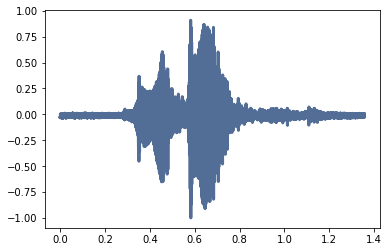

In [149]:
    fragment = thinkdsp.read_wave("Sounds/495520__klankbeeld__child-2-say-buhbuh.wav")
    fragment.plot()

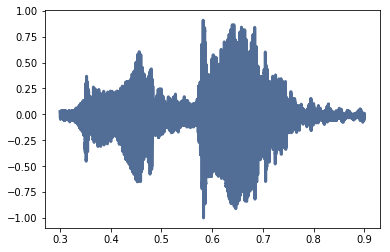

In [150]:
segment = fragment.segment(start=0.3, duration=0.6)
segment.plot()

In [151]:
segment.write(filename='output.wav')

Writing output.wav


In [152]:
def findsilence(y,sr,ind_i):
    hop = int(round(sr*0.2)) #hop and width defines search window
    width = int(sr*0.2)
    n_slice = int(len(y)/hop)
    starts = np.arange(n_slice)*hop
    ends = starts+width
    if hop != width:
        cutoff = np.argmax(ends>len(y))
        starts = starts[:cutoff]
        ends = ends[:cutoff]
        n_slice = len(starts)
    mask = map(lambda i: np.dot(y[starts[i]:ends[i]],y[starts[i]:ends[i]])//width, range(n_slice)) < 0.04 * np.dot(y,y)//len(y)
    starts =  list(compress(starts+ind_i,mask))
    ends = list(compress(ends+ind_i,mask))
    return zip(starts,ends)

def merger(tulist):
    tu=()
    for tt in tulist:
         tu += tt
    cnt = Counter(tu)
    res = filter(lambda x: cnt[x]<2, tu)
    return map(lambda x: tuple(x),np.array(res).reshape((len(res)/2,2)))

def shade_silence(filename,start=0,end=None,disp=True,output=False, itr=''):
    """Find signal (as output) or silence (as shaded reagion  in plot) in a audio file
    filename: (filepath) works best with .wav format
    start/end: (float or int) start/end time for duration of interest in second (default= entire length)
    disp: (bool) whether to display a plot(default= True)
    output: (bool) whether to return an output (default = False)
    itr: (int) iteration use for debugging purpose
    """
    try:
        y, sr = librosa.load(filename)
    except:
        obj = thinkdsp.read_wave(filename)
        y = obj.ys
        sr = obj.framerate
        print itr, ' : librosa.load failed for '+filename

    t = np.arange(len(y))/sr

    i = int(round(start * sr))
    if end != None:
        j = int(round(end * sr))
    else:
        j = len(y)
    fills = findsilence(y[i:j],sr,i)
    if disp:
        fig, ax = plt.subplots()
        ax.set_title(filename)
        ax.plot(t[i:j],y[i:j])
    if fills != None:
        shades = map(lambda x: (max(x[0],i),min(x[1],j)), fills)
        if len(shades)>0:
            shades = merger(shades)
            if disp:
                for s in shades:
                    ax.axvspan(s[0]/sr, s[1]/sr, alpha=0.5, color='red')
    if len(shades)>1:
        live = map(lambda i: (shades[i][1],shades[i+1][0]),xrange(len(shades)-1))
    elif len(shades)==1:
        a = [i,shades[0][0],shades[0][1],j]
        live = filter(lambda x: x != None, map(lambda x: tuple(x) if x[0]!=x[1] else None,np.sort(a).reshape((int(len(a)/2),2))))
    else:
        live = [(i,j)]
    if output:
        return live, sr, len(y)
    
def post2df(filepathlist):
    active=[]
    srs=[]
    dur=[]
    i=0
    print (filepathlist)
    tlist, sr , leng = shade_silence(filepathlist, disp=False, output=True, itr=i)
    active.append(tlist)
    srs.append(sr)
    dur.append(leng/sr)
    i+=1
    return active, srs, dur

def runslice(path2dfpkl,path2files):
    with open (path2dfpkl) as f:
        df = pickle.load(f)
    df['active_region'], df['sr'], df['duration'] = post2df(path2files)
    return df

In [153]:
fileName = "Sounds"
if 1==0:
    pickling_on = file("Pickles/Zample1.pkl","wb")
    pickle.dump(fragment, pickling_on)
pickling_on2 = file("Pickles/Zample2.pkl","wb")
pickle.dump("a", pickling_on2)

In [154]:
fileObject = "Pickles/Zample2.pkl"
oldFileObject= "Sounds/495520__klankbeeld__child-2-say-buhbuh.wav"
runslice(fileObject,oldFileObject).write(filename='newWave.wav')

Sounds/495520__klankbeeld__child-2-say-buhbuh.wav


TypeError: 'str' object does not support item assignment